In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri May 10 22:51:42 2019

@author: bugra,
@author: oguzhan
"""
import os 
import random
import numpy as np  # lineer cebir
import pandas as pd  # veri işeme / input output dosya işlemleri
import matplotlib.pyplot as plt
from IPython.display import display


data = pd.read_csv("autos.csv", encoding = "ISO-8859-1") 
#veri dosyasını okuma

display(data.head(4).transpose()) 
display(data.tail(3).transpose())

fields_to_check=['dateCrawled','name','abtest','vehicleType','gearbox','model','fuelType',\
                 'brand','notRepairedDamage','dateCreated','lastSeen']  
#kontrol edilecek fieldlar
for field in fields_to_check:
    print("Alanlarda {} boş değer var '{}'.".format(len(data[data[field]=='']),field)) 
#boş değerleri yazdır
    
display(data[data['price']<data.price.quantile(0.999)].price.describe())    
# resim sayısı tüm ilanlarda aynı oldugu icin cıkarılıyor
input_data=data.drop('nrOfPictures',1)  
input_data=input_data[input_data['seller']=='privat']    
input_data=input_data[input_data['offerType']=='Angebot']
input_data=input_data.drop(['seller','offerType'],1) 
#private offerlar az olduğu için çıkarılıyor

input_data=input_data[input_data['gearbox']!=''] 
input_data=input_data[input_data['vehicleType']!='']
input_data=input_data[input_data['fuelType']!='']
input_data=input_data[input_data['notRepairedDamage']!='']

model_set=set(input_data.model.str.upper())
#model_set.remove('')
input_data.name=input_data.name.str.upper()
input_data.name=input_data.name.str.split('_')
# Model ismi bulunmayanların isim alanına name atanıyor.
for index,row in input_data.iterrows():        
    if input_data.model[index]=='':
        for name_pcs in input_data.name[index]:
            if name_pcs in model_set:
                input_data.loc[index,'model']=name_pcs
                break
input_data=input_data[input_data['model']!='']
input_data.model=input_data.model.str.upper()
input_data.brand=input_data.brand.str.upper()
input_data=input_data.drop('name',1)  
#name e ihtiyaç olmadıgı icin droplanıyor.
input_data=input_data[input_data['price']!=0]
input_data=input_data[(input_data.powerPS>0) & (input_data.powerPS<=1500)]
input_data=input_data[(input_data.yearOfRegistration>=1950) & (input_data.yearOfRegistration<2017)]
input_data=input_data[input_data['monthOfRegistration']!=0]
input_data=input_data[input_data.price<input_data.price.quantile(0.999)]    
#%1 top fiyatlar çıkarılıyor
# Tarih değerleri önce stringe çevirilip sonra numerik verilere dönüştürülüyor.
input_data.dateCrawled=pd.to_datetime(input_data.dateCrawled)          
level_dateCrawled=input_data['dateCrawled'].min()-np.timedelta64(1,'D')
input_data.dateCrawled=(input_data['dateCrawled'] - level_dateCrawled)/np.timedelta64(1,'D')

input_data.dateCreated=pd.to_datetime(input_data.dateCreated)
level_dateCreated=input_data['dateCreated'].min()-np.timedelta64(1,'D')
input_data.dateCreated=(input_data['dateCreated'] - level_dateCreated)/np.timedelta64(1,'D')

input_data.lastSeen=pd.to_datetime(input_data.lastSeen)
level_lastSeen=input_data['lastSeen'].min()-np.timedelta64(1,'D')
input_data.lastSeen=(input_data['lastSeen'] - level_lastSeen)/np.timedelta64(1,'D')

input_data.postalCode=input_data.postalCode.apply(lambda x: str(int(x/1000))) 
#posta kodu ilk 2 hane kalınacak şekilde düzenleniyor.
input_data.monthOfRegistration=input_data.monthOfRegistration.apply(lambda x: str(x))

display(input_data.head(3))
display(input_data.tail(3))
display("Verisetinde işlemeye uygun {} kayıt vardır.".format(len(input_data)))
    
#price yeni bir sete aktarılıyor
price_data=input_data['price']  
#diğer tablodan price çıkarılıyor
features_data=input_data.drop('price',1)  

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()  
#verileri daha kolay işlemek için  0-1 arasına yeniden ölçeklendiriyor.
numerical = ['yearOfRegistration', 'powerPS', 'kilometer','dateCrawled','dateCreated','lastSeen']
features_data[numerical] = scaler.fit_transform(input_data[numerical])   
#Kategorik veriler için dummy değişkenler oluşturuluyor,
features_data = pd.get_dummies(features_data)  
encoded = list(features_data.columns) 
display("One hot encodingden sonra {} özellik vardır ".format(len(encoded))) 
display(encoded)

from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# Feature ve income datasını training ve test kümelerine ayır
# Feature ve price datalar 6:2:2 oranında train test ve validation olarak ayrılır.

X_train_val, X_test, y_train_val, y_test = \
train_test_split(features_data, price_data, test_size = 0.2, random_state = 0)
X_train,X_val,y_train,y_val=\
train_test_split(X_train_val, y_train_val, test_size = 0.25, random_state = 0)

display(features_data.head(3))


print("Train kümesinin {} örneği vardır.".format(X_train.shape[0]))
print("Validation kümesinin {} örneği vardır.".format(X_val.shape[0]))
print("Test kümesinin {} örneği vardır.".format(X_test.shape[0]))


# Decision Tree
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
dtr_prediction = dtr.predict(X_test)
print("Decision Tree")
print(mean_absolute_error(y_test, dtr_prediction))
print(dtr.score(X_test, y_test))


 
# Random Forest
forest_model = RandomForestRegressor()
forest_model.fit(X_train, y_train)
forest_prediction = forest_model.predict(X_test)
print("Random Forest")
print(mean_absolute_error(y_test, forest_prediction))
print(forest_model.score(X_test, y_test))


# Lineer Regression
lm = linear_model.LinearRegression()
lm.fit(X_train,y_train)
y_pred = lm.predict(X_test)
print("Linear Regression")
print(mean_absolute_error(y_test, y_pred))
print(lm.score(X_test,y_test))


X_train=np.array(X_train) #listeler numpy dizilerine dönüştürülür. Sequential için
y_train=np.array(y_train)
X_val=np.array(X_val)
y_val=np.array(y_val)
X_test=np.array(X_test)
y_test=np.array(y_test)

# naive bayes
def naive_price_predictor(X_train,y_train,X_test,y_test):
    mean=np.mean(y_train)
    prediction=mean*np.ones(y_test.shape)
    return prediction

naive_prediction=naive_price_predictor(X_train,y_train,X_test,y_test)
display(naive_prediction)

def self_defined_error_func(y_test,y_pred):
    err=np.mean(np.abs(y_test-y_pred))
    return err

naive_prediction_score=self_defined_error_func(y_test,naive_prediction)
display('The naive model gets a score of {} for the test set.'.format(naive_prediction_score))


from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint, Callback

loss_function='mean_absolute_error' 
#kayıp fonksiyonu mean absolute error olarak seçilir.

price_predictor = Sequential()  
#sequential modeli, compile-fit-evaluate-predict methodlarını kullanmak için oluşturuluyor
#relu aktivasyonu ile nöron ağı katmanları oluşturuluyor
price_predictor.add(Dense(128,activation='relu', input_dim=424))  
price_predictor.add(Dense(64))
price_predictor.add(Dense(32,activation='relu'))
price_predictor.add(Dense(8))
price_predictor.add(Dense(1))
price_predictor.summary()

price_predictor.compile(optimizer='Adam', loss=loss_function)
#compile, modeli eğitim için yapılandırır. Burada Adam optimizer'ı(stochastic gradient descent'ın farklı türü) kullanılmıştır.
#base class'ı soyutlayarak yeni callbacklere imkan verir.
checkpointer = ModelCheckpoint(filepath='price_model_best.hdf5', 
                               verbose=1, save_best_only=True)
price_predictor.fit(X_train, y_train, 
          validation_data=[X_val,y_val],
          epochs=20, batch_size=500, callbacks=[checkpointer],verbose=0) 
#fit, modeli verilen epoch sayısına göre eğitir.

price_predictor.load_weights('price_model_best.hdf5')
score=price_predictor.evaluate(X_test,y_test,verbose=1) 
#evaluate kayıp değerleri döndürür.
display("Son model test verisi için {} skor almaktadır.".format(score))

price_prediction=price_predictor.predict(X_test) 
#test verisi için price tahmini output olarak predict ile yaptırlıyor.

,0,1,2,3
dateCrawled,2016-03-24 11:52:17,2016-03-24 10:58:45,2016-03-14 12:52:21,2016-03-17 16:54:04
name,Golf_3_1.6,A5_Sportback_2.7_Tdi,"Jeep_Grand_Cherokee_""Overland""",GOLF_4_1_4__3TÜRER
seller,privat,privat,privat,privat
offerType,Angebot,Angebot,Angebot,Angebot
price,480,18300,9800,1500
abtest,test,test,test,test
vehicleType,NaN,coupe,suv,kleinwagen
yearOfRegistration,1993,2011,2004,2001
gearbox,manuell,manuell,automatik,manuell
powerPS,0,190,163,75


,371525,371526,371527
dateCrawled,2016-03-19 18:57:12,2016-03-20 19:41:08,2016-03-07 19:39:19
name,Volkswagen_Multivan_T4_TDI_7DC_UY2,VW_Golf_Kombi_1_9l_TDI,BMW_M135i_vollausgestattet_NP_52.720____Euro
seller,privat,privat,privat
offerType,Angebot,Angebot,Angebot
price,9200,3400,28990
abtest,test,test,control
vehicleType,bus,kombi,limousine
yearOfRegistration,1996,2002,2013
gearbox,manuell,manuell,manuell
powerPS,102,100,320


Alanlarda 0 boş değer var 'dateCrawled'.
Alanlarda 0 boş değer var 'name'.
Alanlarda 0 boş değer var 'abtest'.
Alanlarda 0 boş değer var 'vehicleType'.
Alanlarda 0 boş değer var 'gearbox'.
Alanlarda 0 boş değer var 'model'.
Alanlarda 0 boş değer var 'fuelType'.
Alanlarda 0 boş değer var 'brand'.
Alanlarda 0 boş değer var 'notRepairedDamage'.
Alanlarda 0 boş değer var 'dateCreated'.
Alanlarda 0 boş değer var 'lastSeen'.


count    371156.000000
mean       5616.158338
std        7559.086800
min           0.000000
25%        1150.000000
50%        2950.000000
75%        7200.000000
max      108500.000000
Name: price, dtype: float64

,dateCrawled,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode,lastSeen
1,19.869711,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,AUDI,ja,231.0,66,33.480347
2,9.948600,9800,test,suv,2004,automatik,163,GRAND,125000,8,diesel,JEEP,NaN,221.0,90,31.939329
3,13.116458,1500,test,kleinwagen,2001,manuell,75,GOLF,150000,6,benzin,VOLKSWAGEN,nein,224.0,91,13.142465


,dateCrawled,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode,lastSeen
371525,15.201968,9200,test,bus,1996,manuell,102,TRANSPORTER,150000,3,diesel,VOLKSWAGEN,nein,226.0,87,33.708542
371526,16.232477,3400,test,kombi,2002,manuell,100,GOLF,150000,6,diesel,VOLKSWAGEN,NaN,227.0,40,19.937650
371527,3.231215,28990,control,limousine,2013,manuell,320,M_REIHE,50000,8,benzin,BMW,nein,214.0,73,17.543079


'Verisetinde işlemeye uygun 294645 kayıt vardır.'

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


'One hot encodingden sonra 424 özellik vardır '

['dateCrawled',
 'yearOfRegistration',
 'powerPS',
 'kilometer',
 'dateCreated',
 'lastSeen',
 'abtest_control',
 'abtest_test',
 'vehicleType_andere',
 'vehicleType_bus',
 'vehicleType_cabrio',
 'vehicleType_coupe',
 'vehicleType_kleinwagen',
 'vehicleType_kombi',
 'vehicleType_limousine',
 'vehicleType_suv',
 'gearbox_automatik',
 'gearbox_manuell',
 'model_100',
 'model_145',
 'model_147',
 'model_156',
 'model_159',
 'model_1ER',
 'model_1_REIHE',
 'model_200',
 'model_2_REIHE',
 'model_300C',
 'model_3ER',
 'model_3_REIHE',
 'model_4_REIHE',
 'model_500',
 'model_5ER',
 'model_5_REIHE',
 'model_601',
 'model_6ER',
 'model_6_REIHE',
 'model_7ER',
 'model_80',
 'model_850',
 'model_90',
 'model_900',
 'model_9000',
 'model_911',
 'model_A1',
 'model_A2',
 'model_A3',
 'model_A4',
 'model_A5',
 'model_A6',
 'model_A8',
 'model_ACCORD',
 'model_AGILA',
 'model_ALHAMBRA',
 'model_ALMERA',
 'model_ALTEA',
 'model_AMAROK',
 'model_ANDERE',
 'model_ANTARA',
 'model_AROSA',
 'model_ASTRA',

,dateCrawled,yearOfRegistration,powerPS,kilometer,dateCreated,lastSeen,abtest_control,abtest_test,vehicleType_andere,vehicleType_bus,vehicleType_cabrio,vehicleType_coupe,vehicleType_kleinwagen,vehicleType_kombi,vehicleType_limousine,vehicleType_suv,gearbox_automatik,gearbox_manuell,model_100,model_145,model_147,model_156,model_159,model_1ER,model_1_REIHE,model_200,model_2_REIHE,model_300C,model_3ER,model_3_REIHE,model_4_REIHE,model_500,model_5ER,model_5_REIHE,model_601,model_6ER,model_6_REIHE,model_7ER,model_80,model_850,...,postalCode_63,postalCode_64,postalCode_65,postalCode_66,postalCode_67,postalCode_68,postalCode_69,postalCode_7,postalCode_70,postalCode_71,postalCode_72,postalCode_73,postalCode_74,postalCode_75,postalCode_76,postalCode_77,postalCode_78,postalCode_79,postalCode_8,postalCode_80,postalCode_81,postalCode_82,postalCode_83,postalCode_84,postalCode_85,postalCode_86,postalCode_87,postalCode_88,postalCode_89,postalCode_9,postalCode_90,postalCode_91,postalCode_92,postalCode_93,postalCode_94,postalCode_95,postalCode_96,postalCode_97,postalCode_98,postalCode_99
1,0.571441,0.924242,0.126084,0.827586,0.942623,0.983348,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.270995,0.818182,0.108072,0.827586,0.901639,0.936694,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0.366929,0.772727,0.049366,1.000000,0.913934,0.367615,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


Train kümesinin 176787 örneği vardır.
Validation kümesinin 58929 örneği vardır.
Test kümesinin 58929 örneği vardır.
Decision Tree
1581.905207962124
0.8080076420222883


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest
1273.3241239457652
0.8764291991889738
Linear Regression
4609761.378483005
-19070534750.74068


array([6390.65659805, 6390.65659805, 6390.65659805, ..., 6390.65659805,
       6390.65659805, 6390.65659805])

'The naive model gets a score of 5314.553645407248 for the test set.'

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               54400     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 65,009
Trainable params: 65,009
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.

Epoch 00001: val_

'Son model test verisi için 1373.782463544086 skor almaktadır.'

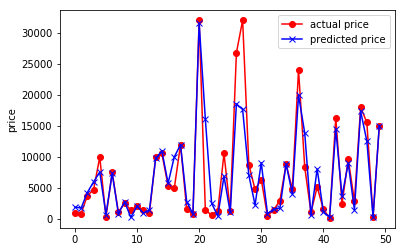

In [2]:
#rastgele 50 değer için gerçek ve tahmini fiyat karşılaştırılası grafiği çiziliyor.
#decision tree
num_samples=50
idx=random.sample(range(len(y_test)),num_samples) 
plt.plot(range(num_samples),y_test[idx],'ro-')
plt.plot(range(num_samples),dtr_prediction[idx],'bx-')
plt.ylabel("price")
plt.legend(["actual price",'predicted price','mean price'])

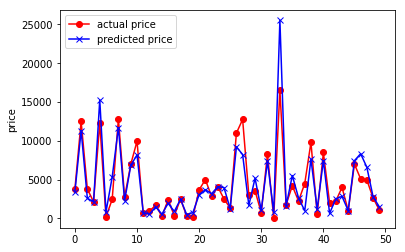

In [3]:
#random forest
num_samples=50
idx=random.sample(range(len(y_test)),num_samples) 
plt.plot(range(num_samples),y_test[idx],'ro-')
plt.plot(range(num_samples),forest_prediction[idx],'bx-')
plt.ylabel("price")
plt.legend(["actual price",'predicted price','mean price'])

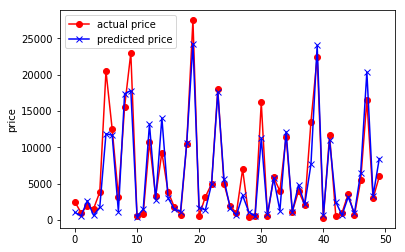

In [4]:
#yapay sinir ağı
num_samples=50
idx=random.sample(range(len(y_test)),num_samples) 
plt.plot(range(num_samples),y_test[idx],'ro-')
plt.plot(range(num_samples),price_prediction[idx],'bx-')
plt.ylabel("price")
plt.legend(["actual price",'predicted price','mean price'])